# Lotka Volterra UPINN

In [37]:
import torch
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import pysindy as ps
from kan import KAN

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from upinn import UPINN
from architectures import FNN, ResNet
from LotkaVolterraData import LotkaVolterraData
from utils import SINDy_sklearn, sample_collocation_points

# This problem is so small that the GPU overhead is slower than using the CPU
device = 'cpu'

Consider the Lotka-Volterra equations, which describe the dynamics of a predator-prey system:

\begin{align}
\frac{dx}{dt} &= \alpha x - \beta x y, \\
\frac{dy}{dt} &= - \delta y + \gamma x y,
\end{align}

where $x$ is the number of prey, $y$ is the number of predators, and $\alpha$, $\beta$, $\gamma$, and $\delta$ are positive constants.

## Generate Data from System

In [38]:
# Data
alpha, beta, gamma, delta = 2/3, 4/3, 1.0, 1.0
X0 = torch.tensor([1.0, 1.0]).reshape(-1, 2)

Nd = 10 # Number of data points

time_int = [0, 10]
spacing = (time_int[1] - time_int[0]) / Nd

data_time_points = np.linspace(time_int[0]+spacing, time_int[1], Nd)

data = LotkaVolterraData(X0, alpha, beta, gamma, delta, time_int, time_points=data_time_points, noise_level=0.0)

td = data.td
Xd = data.Xd

In [39]:
# Boundary conditions
tbc = torch.tensor([[0.0]])
Xbc = X0

In [40]:
# Collocation points
N_coll = 1000
tc = sample_collocation_points(N_coll, 1, lb=[time_int[0]], ub=[time_int[1]], method='grid')

### Known system $N_K$

Assume that $\gamma x y$ is not known, and we want to learn it from data.

In [41]:
class SparseLV(torch.nn.Module):
    
    def __init__(self, params):
        super(SparseLV, self).__init__()
        self.alpha = params['alpha']
        self.beta = params['beta']
        self.delta = params['delta']
        self.gamma = params['gamma']
        self.log = dict()

    def forward(self, z, U):

        dUdt = torch.cat([
        torch.autograd.grad(outputs=U[:, i], inputs=z, grad_outputs=torch.ones_like(U[:, i]), create_graph=True)[0]
        for i in range(U.shape[1])
        ], dim=-1)

        # self.log.setdefault('alpha', []).append(self.alpha.item())
        # self.log.setdefault('delta', []).append(self.delta.item())

        return torch.stack([
            (dUdt[:, 0] - self.alpha*U[:, 0]), # + beta*U[:, 0]*U[:, 1],
            (dUdt[:, 1] + self.delta*U[:, 1]) # - gamma*U[:, 0]*U[:, 1] # <-- Estimate this
        ], dim=-1)


params = dict(
    alpha=alpha,
    # alpha=torch.nn.Parameter(torch.tensor(1.0)),
    beta=beta,
    # delta=torch.nn.Parameter(torch.tensor(1.0)),
    delta=delta,
    gamma=gamma
)

N = SparseLV(params)

### Problem specific UPINN functions

In [42]:
psi = torch.nn.Parameter(torch.tensor(1.0))

In [43]:
class LV_UPINN(UPINN):

    # def set_psi(self):
    #     self.phi = torch.nn.Parameter(torch.tensor(1.0))

    # def get_loss(self):
    #     bc_loss = self.bc_loss()
    #     data_loss = self.data_loss()
    #     pde_loss = self.pde_loss()
    #     lambdas = SoftAdapt(**self.softadapt_kwargs)(torch.tensor([bc_loss, data_loss, pde_loss]))
    #     loss = lambdas[0]*bc_loss + lambdas[1]*data_loss + lambdas[2]*pde_loss

    #     return loss, bc_loss, data_loss, pde_loss

    def F_input(self, z, U):
        return U

    def score(self):
        u_pred = self.u(data.t_full)

        L2_rel_error = torch.sqrt(torch.mean((u_pred - data.X_full)**2) / torch.mean(data.X_full**2))
        return L2_rel_error.item()

        # return torch.nn.MSELoss()(u_pred, data.X_full)
    
    def score_residual(self):
        u_pred = self.u(data.t_full)
        F_pred = self.F(self.F_input(data.t_full, u_pred))

        # self.shared_res = True
        # if self.shared_res:
        #     F_pred = torch.cat((F_pred, self.psi*F_pred), dim=1)
               
        F_exp_1 = beta*u_pred[:, 0]*u_pred[:, 1]
        F_exp_2 = -gamma*u_pred[:, 0]*u_pred[:, 1]
        F_exp = torch.stack([F_exp_1, F_exp_2], dim=-1)

        L2_rel_error = torch.sqrt(torch.mean((F_pred - F_exp)**2) / torch.mean(F_exp**2))
        return L2_rel_error.item()

    
    def pde_loss(self):
        # self.log.setdefault('psi', []).append(self.psi.item())
        if self.collocation_points is not None:
            U_c = self.u(self.collocation_points)
            res = self.F(self.F_input(self.collocation_points, U_c))

            # self.shared_res = True
            # if self.shared_res:
            #     res = torch.cat((res, self.psi*res), dim=1)

            known = self.N(self.collocation_points, U_c)
            pde_loss = torch.nn.MSELoss()(known, -res) if self.collocation_points.shape[0] > 0 else torch.tensor(0.0)
        else: pde_loss = torch.tensor(0.0)
        return pde_loss
    
    def get_loss(self):
        bc_loss = self.bc_loss()
        data_loss = self.data_loss()
        pde_loss = self.pde_loss()
        res_loss = torch.mean(torch.abs(self.F(self.F_input(self.collocation_points, self.u(self.collocation_points)))))
        # self.log.setdefault('res_loss', []).append(res_loss.item())

        U_c = self.u(self.collocation_points)
        res = self.F(self.F_input(self.collocation_points, U_c))
        # Correllation loss
        U_c_norm = U_c / (torch.norm(U_c, dim=0)+1e-8)
        res_norm = res / (torch.norm(res, dim=0)+1e-8)

        temp = torch.mean(torch.diag(U_c_norm.T @ res_norm)**2)

        loss = self.lambdas[0]*bc_loss + self.lambdas[1]*data_loss + self.lambdas[2]*pde_loss + 1e-3*temp

        return loss, bc_loss, data_loss, pde_loss


    def plot(self, save=None):
        
        self.to('cpu')

        with torch.no_grad():
            t_plot = data.t_full
            x_true = data.X_full[:, 0:1]
            y_true = data.X_full[:, 1:2]

            u_pred = self.u(self.collocation_points)
            F_pred = self.F(self.F_input(t_plot, u_pred))

            x_pred = u_pred[:, 0]
            y_pred = u_pred[:, 1]

            fig, ax = plt.subplots(2, 1, figsize=(8, 6))
            plt.subplot(2, 1, 1)
            plt.plot(td, Xd[:, 0], 'ro')
            plt.plot(t_plot, x_pred, 'r', label='Pred. Predator')
            plt.plot(t_plot, x_true, 'r--', label='True Predator')
            plt.plot(td, Xd[:, 1], 'bo')
            plt.plot(t_plot, y_pred, 'b', label='Pred. Prey')
            plt.plot(t_plot, y_true, 'b--', label='True Prey')
            plt.scatter(td, Xd[:, 0], color='r', s=1)
            plt.scatter(td, Xd[:, 1], color='b', s=1)
            plt.xlabel('t')
            plt.legend()
            plt.xlim([time_int[0], time_int[1]])
            plt.ylim([0, 2])
            
            plt.subplot(2, 1, 2)
            plt.plot(t_plot, F_pred[:, 0], 'r', label='Pred. Predator residual')
            plt.plot(t_plot, beta*x_true*y_true, 'r--', label='True Predator residual')
            plt.plot(t_plot, F_pred[:, 1], 'b', label='Pred. Prey residual')
            plt.plot(t_plot, -gamma*x_true*y_true, 'b--', label='True Prey residual')
            plt.xlabel('t')
            plt.legend()
            plt.xlim([time_int[0], time_int[1]])
            plt.ylim([-1.5, 2])
            plt.tight_layout()
            plt.legend( loc='upper center', bbox_to_anchor=(0.3, 1.0))

            if save is not None:
                plt.savefig('gfx/'+save+'.pdf', format='pdf', bbox_inches='tight')

            plt.show()


### Setup UPINN

In [44]:
# Define model architectures
hidden = [16] * 4
u = FNN(
    dims=[1, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.SiLU(),
)
# F = FNN(
#     dims=[2, *hidden, 2],
#     hidden_act=torch.nn.Tanh(),
#     output_act=torch.nn.Identity(),
# )

F = KAN([2, 2, 2], grid=5)

checkpoint directory created: ./model
saving model version 0.0


In [45]:
model = LV_UPINN(u, N, F, boundary_points=(tbc, Xbc), data_points=(td, Xd), collocation_points=tc)
# model.set_psi()
# F.phi = torch.nn.Parameter(torch.tensor(1.0))

[Info]: Initializing UPINN model


In [46]:
# np.save('lv_kan_fnn.npy', model.log)

In [47]:
# model.save('lv_kan_fnn', 'models')

### Train

In [48]:
adamw = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(adamw, factor=0.8, patience=1000, threshold=1e-3)
model.scheduler = scheduler
model.optimizer = adamw

In [49]:
# F.phi = torch.nn.Parameter(torch.tensor(1.0))

In [50]:
# model.load('lv_baseline_unknown_alpha_delta_betaxy_gammaxy', 'models')

In [52]:
model.train_loop(5000)

[Info]: Training 5000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 5000/5000 [04:54<00:00, 16.96 epoch/s, bc_loss=1.18e-08, data_loss=2.43e-06, pde_loss=3.64e-06, loss=8.22e-04]


In [53]:
model.score()

0.0020522791892290115

In [44]:
model.F.auto_symbolic()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [55]:
model.F.refine(10)

saving model version 0.1


MultKAN(
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)

In [53]:
model.score()

0.0014074641512706876

In [55]:
model.to('cuda')

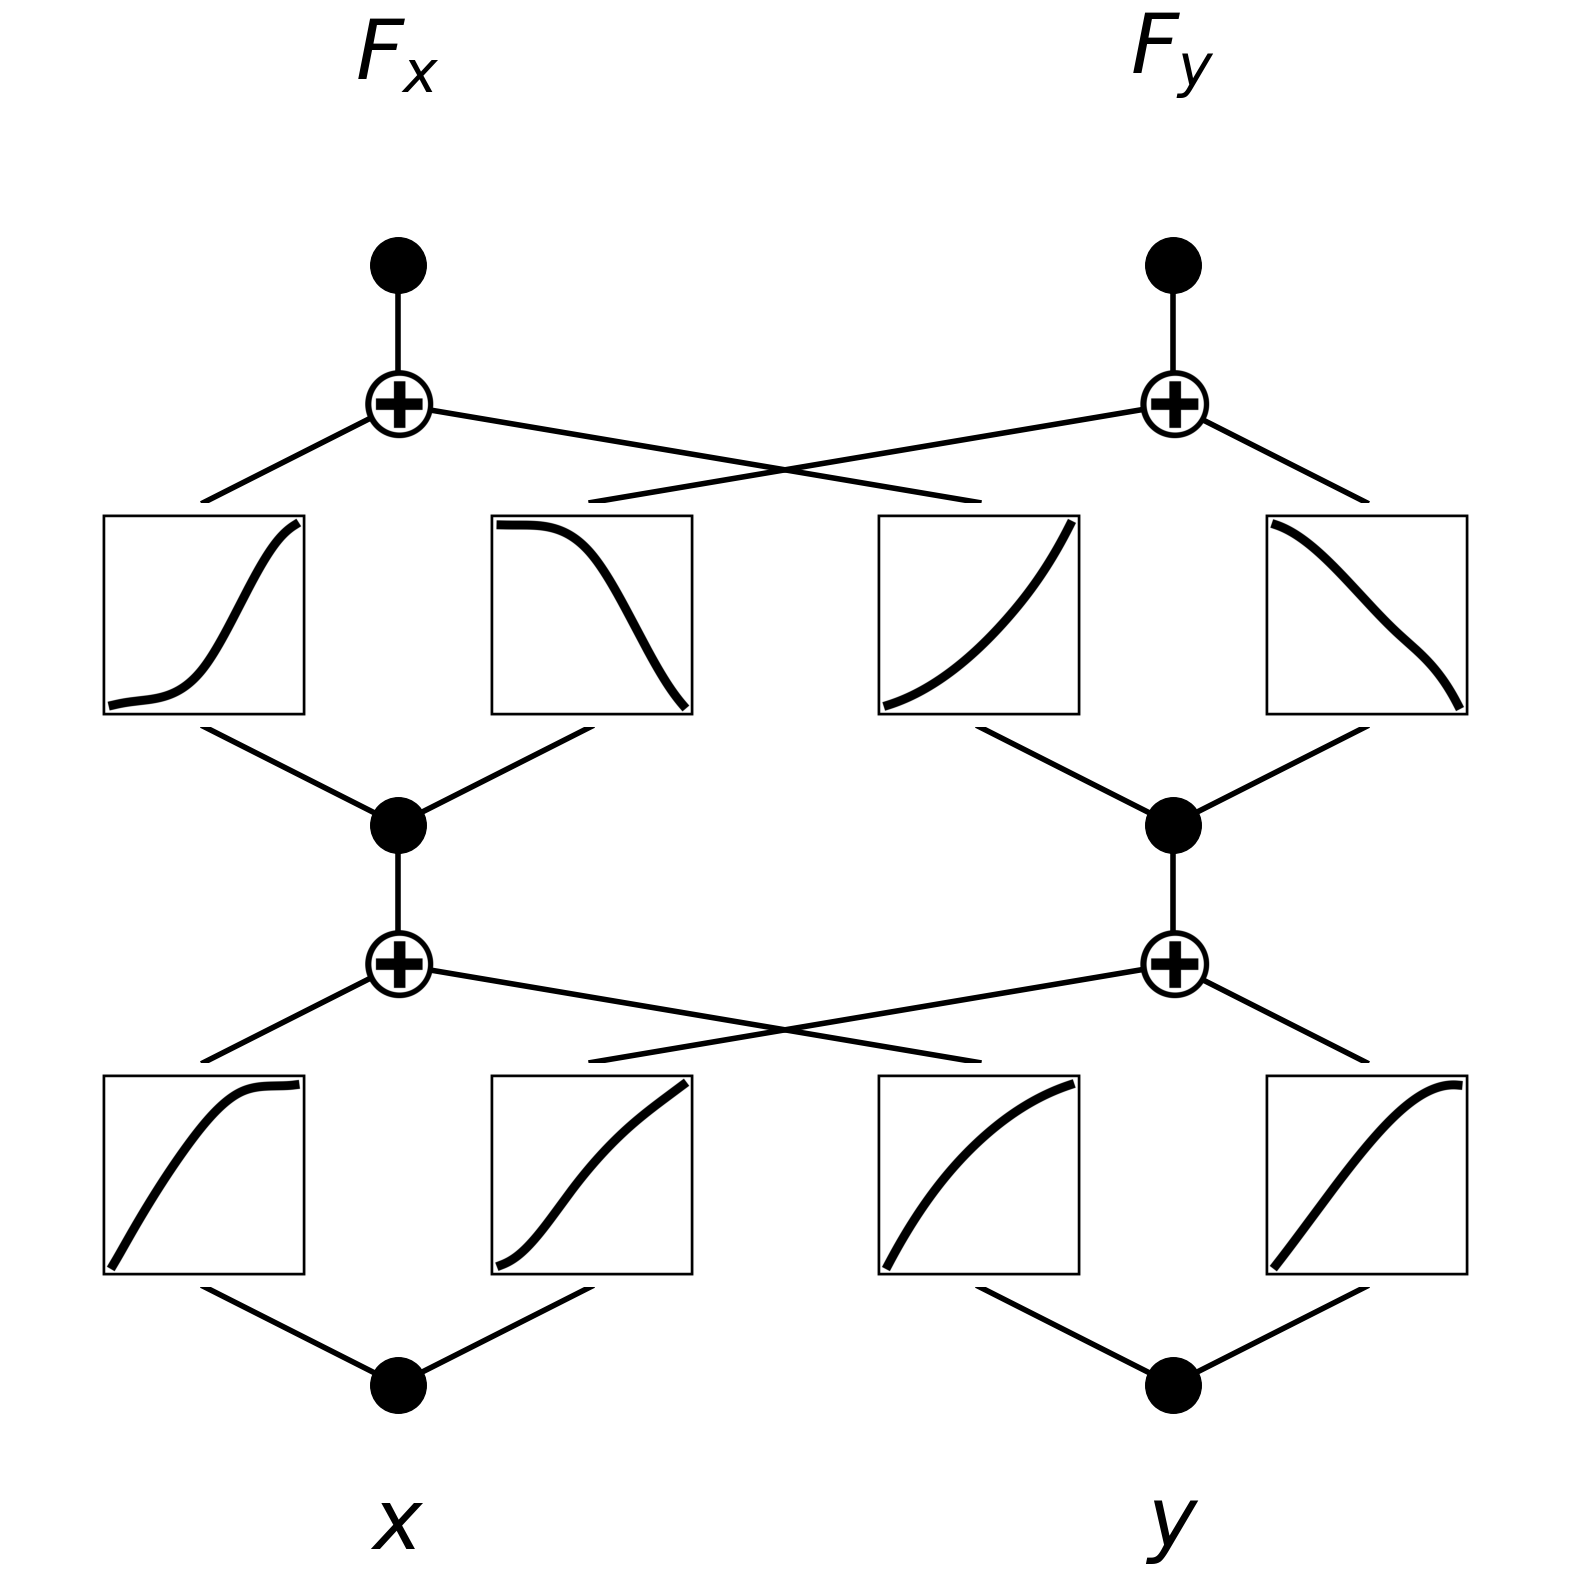

In [56]:
model.F.plot(folder='gfx', in_vars=[r'$x$', r'$y$'], out_vars=[r'$F_x$', r'$F_y$'], varscale=0.75, scale=2, beta=1000)

In [33]:
fig.savefig('gfx/lv_kan.pdf', format='pdf', bbox_inches='tight')

AttributeError: 'NoneType' object has no attribute 'savefig'

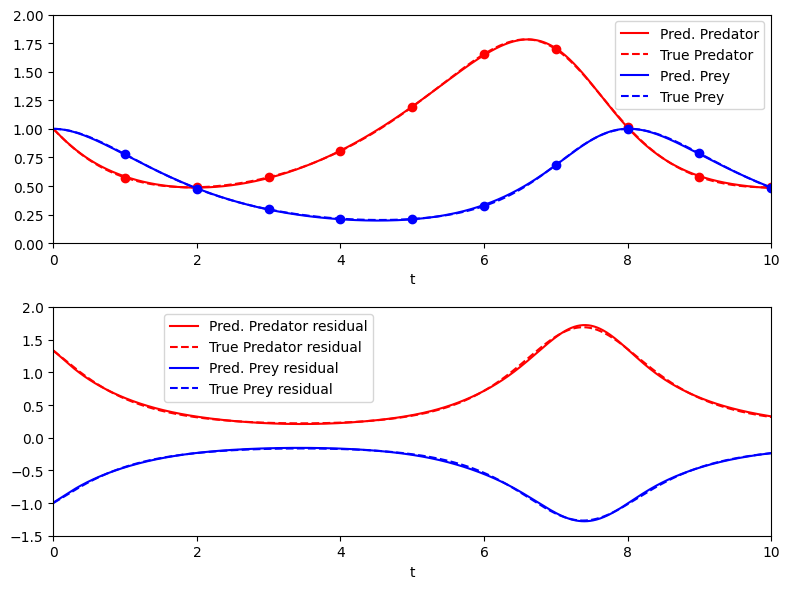

In [15]:
model.plot()

In [245]:
model.to('cpu')

In [173]:
model.N.alpha.item()

0.6662312150001526

In [246]:
print(model.score(), model.score_residual())

0.0018936938140541315 0.010423416271805763


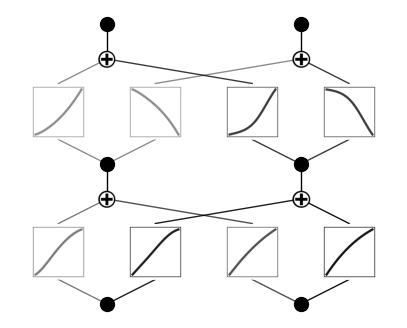

In [ ]:
model.F.plot()

In [ ]:
scheduler.get_last_lr()

[0.000125]

In [ ]:
lib = ['x', 'x^2', 'x^3']

model.F.unfix_symbolic_all()
# model.F.auto_symbolic(lib=lib, weight_simple=0.9)

saving model version 0.40
saving model version 0.41
saving model version 0.42
saving model version 0.43
saving model version 0.44
saving model version 0.45
saving model version 0.46
saving model version 0.47


In [ ]:
model.train_loop(10000, device='cpu')

[Info]: Training 10000 epoch(s) on cpu using AdamW optimizer.


[CPU]:  41%|████      | 4115/10000 [01:55<02:45, 35.50 epoch/s, bc_loss=4.36e-12, data_loss=3.88e-08, pde_loss=4.61e-07, loss=5.00e-07]


KeyboardInterrupt: 

In [ ]:
name = 'lv_baseline_data10_noise0100'
model.load(name, 'models')
np.save('loss/'+name+'_loss.npy', model.log['loss'])

[Info]: Successfully saved total model with name lv_baseline_data10_noise0100 at models


In [ ]:
model.score()

In [ ]:
model.score_residual()

0.010308738797903061

In [ ]:
# model.save('lv-unknown-alpha-gammaxy-betaxy-shared', 'models')

[Info]: Successfully saved total model with name lv-unknown-alpha-gammaxy-betaxy-shared at models


In [ ]:
params['alpha']
# params['delta']

Parameter containing:
tensor(0.8125, requires_grad=True)

In [ ]:
plt.figure(figsize=(8, 2.5))
plt.plot(model.log['loss'], 'b', label='Total loss', linewidth=1)
plt.yscale('log')
plt.xlabel('Epoch')
plt.legend()
plt.xlim([0, 500000])
plt.ylim([1e-7, 1e-0])
# plt.savefig('gfx/lv_baseline_extrapolate_loss.pdf', format='pdf', bbox_inches='tight')
plt.show()


KeyError: 'loss'

<Figure size 800x250 with 0 Axes>

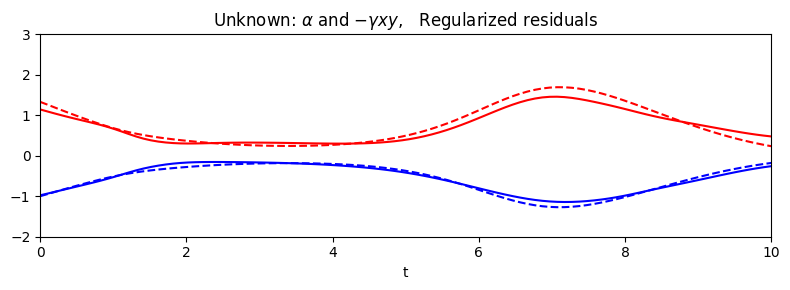

In [270]:
model.to('cpu')
t = torch.linspace(0, time_int[1], 100).reshape(-1, 1)
u = model.u(t).detach()

data_full = LotkaVolterraData(X0, alpha, beta, gamma, delta, [0, 20])

plt.figure(figsize=(8, 3))

# plt.subplot(2, 1, 1)

# plt.plot(t.detach().numpy(), u[:, 0].detach().numpy(), 'r', label='Predicted Predator')
# plt.plot(td[1::2], Xd[1::2, 0], 'ro', markersize=4)
# plt.plot(data_full.t_full, data_full.X_full[:, 0], 'r--', label='True Predator')
# plt.plot(t.detach().numpy(), u[:, 1].detach().numpy(), 'b', label='Predicted Prey')
# plt.plot(td[1::2], Xd[1::2, 1], 'bo', markersize=4)
# plt.plot(data_full.t_full, data_full.X_full[:, 1], 'b--', label='True Prey')
# plt.xlim([0, 10])
# plt.xlabel('t')
# plt.ylim([0, 2])
# plt.legend()

# plt.subplot(2, 1, 2)

F_pred = model.F(model.F_input(t, u)).detach()
plt.plot(t.detach().numpy(), F_pred[:, 0].detach().numpy(), 'r', label='Predicted Predator residual')
plt.plot(t.detach().numpy(), beta*u[:, 0]*u[:, 1], 'r--', label='True Predator residual')
plt.plot(t.detach().numpy(), F_pred[:, 1].detach().numpy(), 'b', label='Predicted Prey residual')
plt.plot(t.detach().numpy(), -gamma*u[:, 0]*u[:, 1], 'b--', label='True Prey residual')
plt.xlabel('t')
plt.xlim([0, 10])
plt.ylim([-2, 3])
# Move the legend to the right
# plt.legend(loc='upper left')
plt.title(r'Unknown: $\alpha$ and $-\gamma x y$,   Regularized residuals')

plt.tight_layout()

# plt.savefig('gfx/lv_baseline_unknown_alpha_gammaxy_reg.pdf', format='pdf', bbox_inches='tight')

plt.show()

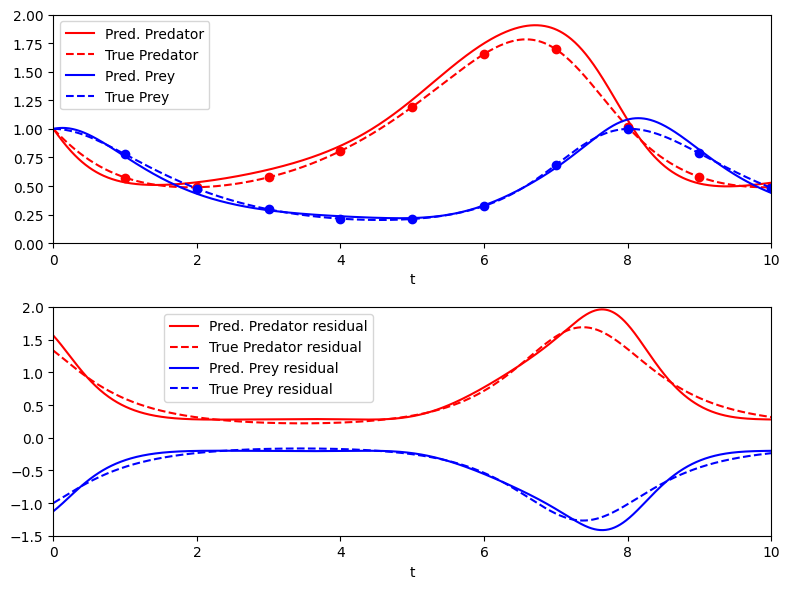

In [336]:
model.plot('lv_data5_noise0100_shared')

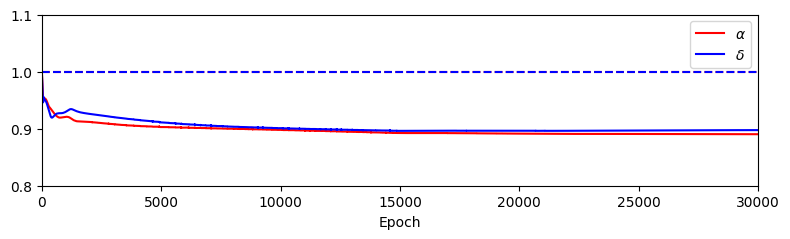

In [ ]:
plt.figure(figsize=(8, 2.5))
plt.plot(N.log['alpha'], 'r', label=r'$\alpha$')
plt.plot([0, 30000], [1, 1], 'r--')
plt.plot(N.log['delta'], 'b', label=r'$\delta$')
plt.plot([0, 30000], [1, 1], 'b--')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.8, 1.1])
plt.xlim([0, 30000])
plt.tight_layout()
# plt.savefig('gfx/lv_baseline_unknown_params_alpha_delta.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
u_pred = model.u(data.t_full)
F_pred = model.F(model.F_input(data.t_full, u_pred))

model.shared_res = True
if model.shared_res:
    F_pred = torch.cat((F_pred, F.phi*F_pred), dim=1)
        
F_exp_1 = beta*u_pred[:, 0]*u_pred[:, 1]
F_exp_2 = -gamma*u_pred[:, 0]*u_pred[:, 1]
F_exp = torch.stack([F_exp_1, F_exp_2], dim=-1)

L2_rel_error = torch.sqrt(torch.mean((F_pred - F_exp)**2) / torch.mean(F_exp**2))

In [ ]:
# upinn.load('lv_upinn_baseline_10_datapoints', 'models')

In [ ]:
from sklearn.metrics import mean_squared_error, mean_poisson_deviance

In [125]:
model.load('lv_baseline_data10_noise0100_shared_res', 'models')

In [411]:
# Generate data from the solution network
# t = data.t_full
t = torch.linspace(0, 10, 1000).reshape(-1, 1)
X = model.u(t)
X_dot = model.F(model.F_input(None, X))
t = t.detach().numpy()
X = X.detach().numpy()
X_dot = X_dot.detach().numpy()

In [425]:
# Hyperparameter tuning using Crossvalidation with TimeSeriesSplit
sindy_model = SINDy_sklearn(feature_names=['x', 'y'], feature_library=ps.PolynomialLibrary(degree=2, include_bias=False), optimizer=ps.SR3(thresholder="L0", max_iter=10000, normalize_columns=True))
paramgrid = dict(optimizer__threshold=np.linspace(0.01, 10.0, 100))

cv_folds = TimeSeriesSplit(n_splits=10)
model_selector = GridSearchCV(sindy_model, param_grid=paramgrid, cv=cv_folds, n_jobs=-1)
wrapped_input = np.concatenate([t, X], axis=1)
model_selector.fit(wrapped_input, X_dot)
best_model = model_selector.best_estimator_

best_model.print()

(x)' = 0.145 x + 1.334 x y
(y)' = 0.099 y + -1.000 x y


In [128]:
model.F.phi

Parameter containing:
tensor(-0.7169, requires_grad=True)

In [422]:
g = ps.SINDy(optimizer=ps.SR3(thresholder="L0", threshold=1.5, max_iter=100000, normalize_columns=True), feature_names=['x', 'y'], feature_library=ps.PolynomialLibrary(degree=2, include_bias=False))
g.fit(X, t=t, x_dot=X_dot)
g.print()

(x)' = 0.145 x + 1.334 x y
(y)' = 0.099 y + -1.000 x y


In [423]:
model.N.delta.item()

0.9000813961029053

In [408]:
model.N.alpha.item()

0.81252521276474